This notebook will tests the model against the test set

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
import lightgbm as lgb
from scipy.cluster import hierarchy as hc
import scipy
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
pd.set_option('display.max_columns', 50)

In [2]:
data_path = 'data/'

In [3]:
test_df = pd.read_pickle(data_path+'test_lgbm.pkl')

In [4]:
with open('x_cols.pickle', 'rb') as f:
    x_cols = pickle.load(f)

In [5]:
# make predictions on test set
import os
test_df['pred_returns'] = 0
for m in os.listdir('models/'):
    if m[-4:] == '.txt':
        print(m)
        model = lgb.Booster(model_file=f'models/{m}')
        preds = model.predict(test_df[x_cols])
        test_df['pred_returns'] += preds/5

model_2.txt
model_3.txt
model_1.txt
model_0.txt
model_4.txt


In [6]:
def conf_interval(train_df=test_df,return_thresh=0.07,N=100,conf=0.95):
    high_returns = train_df.loc[train_df['pred_returns']>=return_thresh]
    high_returns = high_returns['returns']
    mu = high_returns.mean()
    sigma = high_returns.std()
    return mu, stats.norm.interval(conf, loc=mu, scale=sigma/np.sqrt(N))

In [7]:
# 95% confidence interval of test set
mu = test_df['returns'].mean()
sigma = test_df['returns'].std()
N = 100
mu, stats.norm.interval(0.95, loc=mu, scale=sigma/np.sqrt(N))

(0.017220406643603373, (-0.017083484573848687, 0.05152429786105543))

In [8]:
# 95% confidence interval of model on invested loans
mu, ci =conf_interval(train_df=test_df,return_thresh=0.07,N=100,conf=0.95)
mu, ci

(0.07258025434908218, (0.03729374121129273, 0.10786676748687163))

The model generated 7% returns on the test set compared to average retunrs of 1.7%

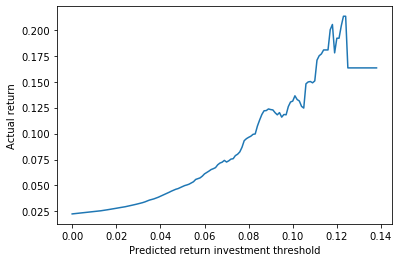

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

returns = []
# for each investment threshold
for t in np.arange(0,0.5, 0.001):
    
    # calculate average returns
    av_return = test_df.loc[test_df['pred_returns']>=t, 'returns'].mean()
    
    # also store how many potential loans there are to invest
    total_loans = len(test_df.loc[test_df['pred_returns']>=t, 'total_pymnt'])
    returns.append((av_return, t, total_loans))

plt.figure()
plt.plot([x[1] for x in returns], [x[0] for x in returns])
plt.xlabel('Predicted return investment threshold')
plt.ylabel('Actual return');

In [10]:
size = len(test_df)

# this shows actual return followed by predicted returnes, and num loans available at that threshold
# limit values to investment thresholds that are available to at least 1% loans
returns = list(filter(lambda x: x[2] > int(size*0.005), returns))
returns.sort(key=lambda x: x[0], reverse=True)
returns[:10]

[(0.07540163035298234, 0.07200000000000001, 1711),
 (0.07414726926677799, 0.069, 2469),
 (0.07373578988875269, 0.07100000000000001, 1935),
 (0.07258025434908218, 0.07, 2191),
 (0.07242537692993575, 0.068, 2766),
 (0.07157386934396942, 0.067, 3133),
 (0.06991775445910593, 0.066, 3553),
 (0.06719830513256617, 0.065, 4012),
 (0.06616316380953755, 0.064, 4547),
 (0.06532307261719551, 0.063, 5159)]

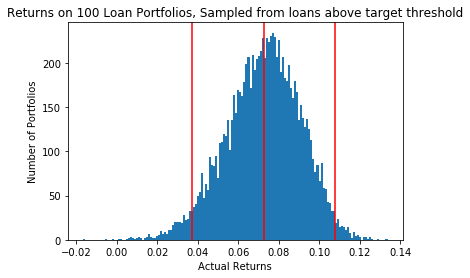

In [11]:
high_returns = test_df.loc[test_df['pred_returns']>=0.07]
high_returns = high_returns['returns']

returns = []
for i in range(10000):
    returns.append(np.random.choice(high_returns,size=100,replace=True).mean())
plt.hist(returns,bins=150)
plt.title('Returns on 100 Loan Portfolios, Sampled from loans above target threshold')
plt.xlabel('Actual Returns')
plt.ylabel('Number of Portfolios')
plt.axvline(x=mu,c='red')
plt.axvline(x=ci[0],c='red')
plt.axvline(x=ci[1],c='red');

In [12]:
len(high_returns)

2191

In [13]:
len(high_returns)/len(test_df)

0.006635251933641424

Explore different thresholds and confidence intervals

In [14]:
conf_interval(train_df=test_df,return_thresh=0.07,N=100,conf=0.95)

(0.07258025434908218, (0.03729374121129273, 0.10786676748687163))

In [15]:
conf_interval(train_df=test_df,return_thresh=0.07,N=100,conf=0.99)

(0.07258025434908218, (0.026205915189114908, 0.11895459350904944))

In [16]:
conf_interval(train_df=test_df,return_thresh=0.075,N=100,conf=0.95)

(0.08008501561290597, (0.044028478281421625, 0.11614155294439032))

In [17]:
conf_interval(train_df=test_df,return_thresh=0.075,N=100,conf=0.99)

(0.08008501561290597, (0.03269869312150703, 0.12747133810430492))